In [ ]:
# !nvidia-smi

In [2]:
# !pip install fastai2
# !pip install git+https://github.com/lgvaz/faststyle.git

In [3]:
from fastai2.basics import *
from fastai2.vision.all import *
from faststyle import *

In [4]:
source = untar_data(URLs.COCO_SAMPLE)

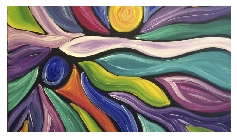

In [5]:
# Fix styles for colab
style_dir = Path('styles')
style_fns = L(style_dir/'abstract.jpg')#, style_dir/'starry_night.jpg')
show_images([PILImage.create(fn) for fn in style_fns])

In [6]:
dblock = DataBlock(style_blocks, get_items=get_image_files, splitter=RandomSplitter(.1),
                   item_tfms=[Resize(128)],
                   batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

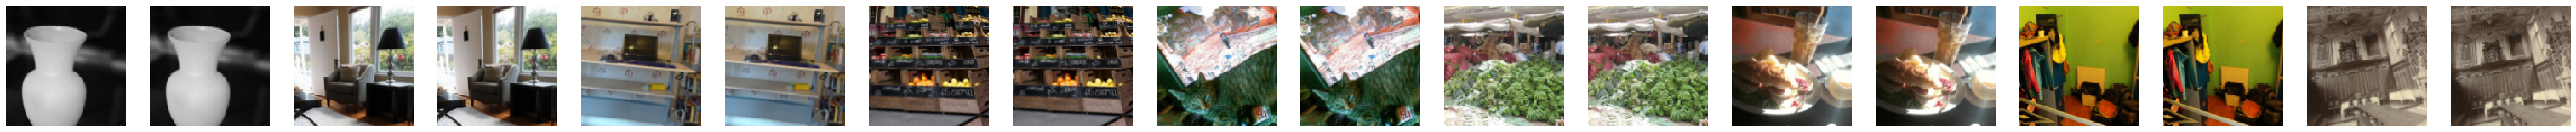

In [7]:
dls = dblock.dataloaders(source, bs=32)
dls.show_batch(rows=1)

In [8]:
from torchvision.models import vgg19
feat_m = vgg19(True).features.cuda().eval()
for p in feat_m.parameters(): p.requires_grad=False

In [9]:
cnt_layers = [feat_m[22]]
stl_layers = []

In [10]:
# def VggFeats(layers):
#   hooks = hook_outputs(layers, detach=False)
#   def _inner(x):
#     feat_m(x)
#     return hooks.stored
#   return _inner
# get_feats = VggFeats(cnt_layers)

In [11]:
def LayerFeats(m, stl_ls, cnt_ls, tfms=None):
  m, tfms = m, Pipeline(tfms)
  stl_hooks = hook_outputs(stl_ls, detach=False)
  cnt_hooks = hook_outputs(cnt_ls, detach=False)
  def _inner(x):
    _ = m(tfms(x))
    return stl_hooks.stored, cnt_hooks.stored
  return _inner

In [12]:
get_feats = LayerFeats(feat_m, stl_layers, cnt_layers, tfms=NormalizeAll.from_stats(*imagenet_stats))

In [14]:
# get_feats = LayerFeats.from_feat_m(FeatModels.vgg19)
# get_feats.tfms = Pipeline([])

In [13]:
class MyLoss(Module):
  def __init__(self, get_feats): self.get_feats=get_feats
#   def forward(self, pred, targ, stl_fts, cnt_fts, **kwargs):
  def forward(self, pred, targ, **kwargs):
    _,pred_cnt = self.get_feats(pred)
    _,targ_cnt = self.get_feats(targ)
    return sum([F.mse_loss(*o) for o in zip(pred_cnt,targ_cnt)])
loss_func = MyLoss(get_feats)

In [16]:
# loss_func = FastStyleLoss(get_feats, cnt_w=0, stl_w=1, tv_w=0)

In [14]:
m = TransformerNet()
# learn = style_learner(dls, m, get_feats, style_fns, loss_func=loss_func, cbs=cbs)
# cbs = SourceFeatsCallback(False,False)
learn = Learner(dls,m,loss_func)

In [18]:
# learn.lr_find()

In [15]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,time
0,31.482489,48.136215,03:30


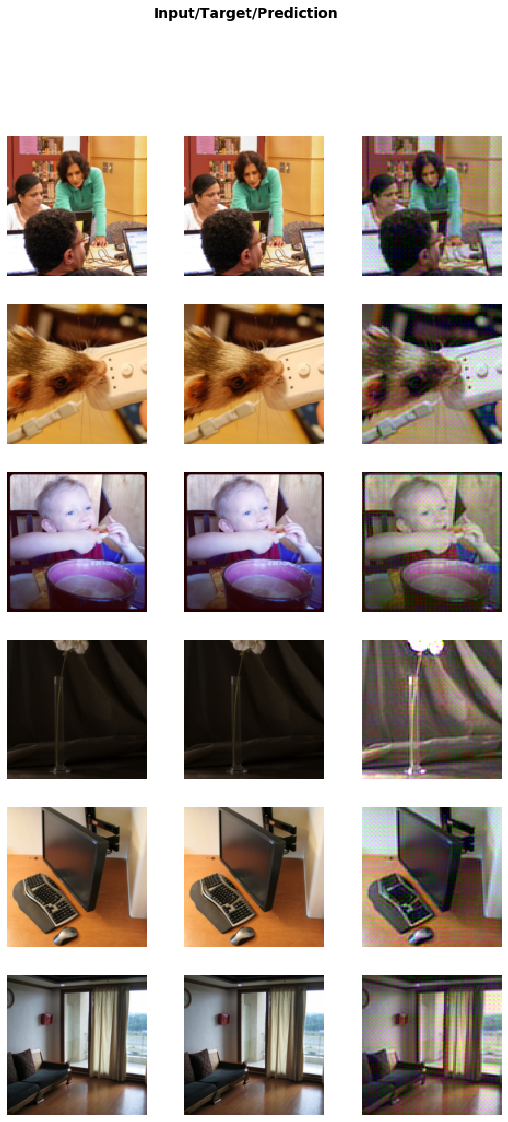

In [16]:
learn.show_results()